<a href="https://colab.research.google.com/github/adildhkh/deep-learning/blob/main/ResNet_blood_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import zipfile
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, Add
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os


# Download dataset
path = kagglehub.dataset_download("paultimothymooney/blood-cells")
print("Path to dataset files:", path)

# If the dataset is zipped, extract it
for file in os.listdir(path):
    if file.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(path, file), 'r') as zip_ref:
            zip_ref.extractall(path)
            print(f"Extracted {file}")

# Check extracted directories
print("Contents of dataset folder:", os.listdir(path))

# Define constants
IMAGE_SIZE = [224, 224]
batch_size = 128

# Base paths
base_path = '/root/.cache/kagglehub/datasets/paultimothymooney/blood-cells/versions/6/dataset2-master/dataset2-master/images'
train_path = os.path.join(base_path, 'TRAIN')  # Training images
valid_path = os.path.join(base_path, 'TEST')  # Validation images (adjust if using TEST_SIMPLE)

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Training set
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation set
validation_set = valid_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

100%|██████████| 108M/108M [00:01<00:00, 85.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/blood-cells/versions/6
Contents of dataset folder: ['dataset-master', 'dataset2-master']
Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [2]:
# Print the number of images in training and validation sets
print(f"Number of images in training set: {training_set.n}")
print(f"Number of images in validation set: {validation_set.n}")


Number of images in training set: 9957
Number of images in validation set: 2487


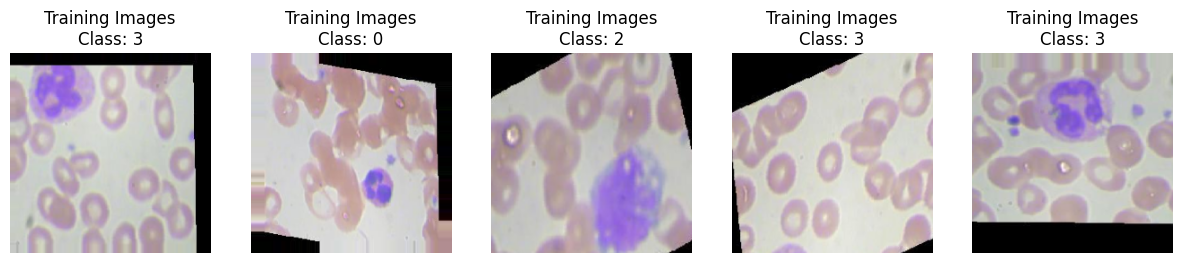

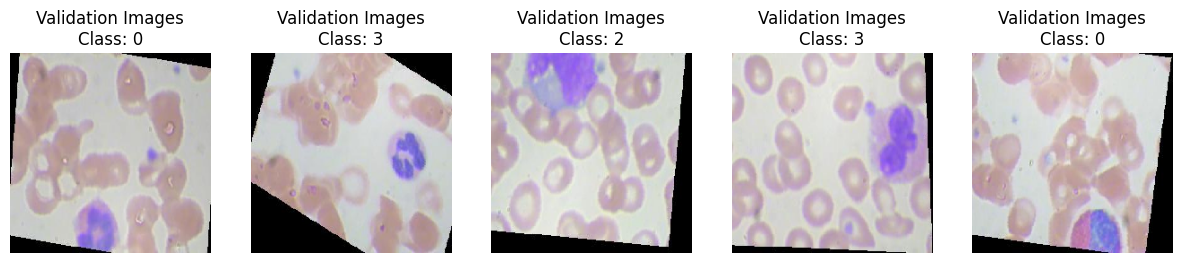

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images(data_generator, title, num_images=5):
    # Get a batch of images and labels
    images, labels = next(data_generator)

    # Select random indices
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Display the images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"{title}\nClass: {np.argmax(labels[idx])}")
        plt.axis('off')
    plt.show()

# Display random training images
show_random_images(training_set, "Training Images")

# Display random validation images
show_random_images(validation_set, "Validation Images")


In [4]:
def identity_block(input_tensor, kernel_size, filters):
    f1, f2, f3 = filters
    # First component of main path
    X = Conv2D(f1, (1, 1))(input_tensor)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(f2, kernel_size, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(f3, (1, 1))(X)
    X = BatchNormalization()(X)

    # Add shortcut to main path
    X = Add()([X, input_tensor])
    X = Activation('relu')(X)

    return X


In [5]:
def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    f1, f2, f3 = filters

    # Shortcut path
    shortcut = Conv2D(f3, (1, 1), strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    # First component of main path
    X = Conv2D(f1, (1, 1), strides=strides)(input_tensor)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(f2, kernel_size, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(f3, (1, 1))(X)
    X = BatchNormalization()(X)

    # Add shortcut to main path
    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X


In [6]:
def build_custom_resnet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Zero Padding
    X = ZeroPadding2D((3, 3))(inputs)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = conv_block(X, 3, [64, 64, 256], strides=(1, 1))
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = conv_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Head of the network
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax')(X)

    model = Model(inputs, X)
    return model


In [7]:
model = build_custom_resnet((224, 224, 3), len(training_set.class_indices))
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 3,065,732 (11.69 MB)

 Trainable params: 3,055,620 (11.66 MB)

 Non-trainable params: 10,112 (39.50 KB)

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath = '/tmp/checkpoint.keras'

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True)
]



In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)


Epoch 1/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5917 - loss: 1.1450 - val_accuracy: 0.2927 - val_loss: 3.9481
Epoch 2/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7736 - loss: 0.6195 - val_accuracy: 0.3193 - val_loss: 4.2669
Epoch 4/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8787 - loss: 0.3561 - val_accuracy: 0.3961 - val_loss: 4.8612
Epoch 6/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8803 - loss: 0.3508 - val_accuracy: 0.5058 - val_loss: 3.2679
Epoch 8/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9310 - loss: 0.1990 - val_accuracy: 0.7294 - val_loss